In [1]:
import os
import numpy as np
import copy
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os
from contextlib import contextmanager
import warnings
warnings.filterwarnings("ignore")
import time

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from utils_unlearn import *
from UNMUNGE import *
from load_datasets import *
from config import *
from dataloader import *

In [2]:
@contextmanager
def suppress_output():
    """Context manager to suppress prints in a block of code."""
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Inputs

In [3]:
dataset_name = 'cifar10'
model_name = 'ResNet18'
retain_data_percent = 100
unlearn_type = 'Single_Class_Unlearn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
retrained_models_folder_name = 'retrained_models'
unlearned_models_folder_name = 'unlearned_models'
delete_saved_unlearned_models = True

learning_rate = 1e-3
unlearn_scale_lr = 2.5
batch_size = 128
num_train_epochs = 30     
num_unlearn_epochs = 5
local_variance = 1
size_multiplier = 1
p = 0.95
tail_randomized=50
solver_type = 'adam'
no_generated_data = 1500
convex_combination = True
eps = 0.01
all_result_folder_path = './results'
result_savepath = ''.join([all_result_folder_path, '/', dataset_name, '/', model_name, '/'])
unlearned_models_path = ''.join([result_savepath, '/', unlearn_type, '/', unlearned_models_folder_name])

# Setting Inputs for models
if dataset_name == 'mnist' or dataset_name == 'fashionMNIST':
    num_input_channels = 1
    num_classes = 10
    padding = 2
elif dataset_name == 'svhn' or dataset_name == 'cifar10':
    num_input_channels = 3
    num_classes = 10
    padding = 0
else:
    print('Details about data not found.')

# Loading Data

In [4]:
# For GPU's
datapath = '/home/rkmvu/Datasets/Torchvision_Data/'
if dataset_name == 'svhn':
    datapath = ''.join([datapath, 'SVHN_Data/'])
if dataset_name == 'cifar100':
    datapath = ''.join([datapath, 'CIFAR100/'])

#-------------------------------------------------------------------------------------------------------------------------------

train_data, test_data = dict_datasets[dataset_name](datapath)
train_loader = DataLoader(train_data,
                          batch_size,
                          shuffle=True
                          )
test_loader = DataLoader(test_data,
                         batch_size,
                         shuffle=True
                         )
image_size = train_loader.dataset[0][0].shape

Using downloaded and verified file: /home/rkmvu/Datasets/Torchvision_Data/cifar10/cifar10.tgz


# Plotting on sample data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.4559333].


Data stats:
--------------------------------------------------------------------------------
Train data size (num_samples x 1-sample size): 50000 x torch.Size([3, 32, 32])
Test data size (num_samples x 1-sample size): 10000  x torch.Size([3, 32, 32])
--------------------------------------------------------------------------------
One train random sample


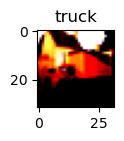

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..2.3245049].


--------------------------------------------------------------------------------
One test random sample


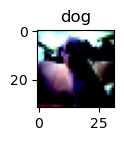

In [5]:
print('='*80)
print('Data stats:')
print('-'*80)
print('Train data size (num_samples x 1-sample size): {} x {}' .format(len(train_data), train_data[0][0].shape))
print('Test data size (num_samples x 1-sample size): {}  x {}' .format(len(test_data), test_data[0][0].shape))
print('-'*80)
print('One train random sample')
train_rand_idx = np.random.choice(len(train_data))

plot_sample_with_label(train_data[train_rand_idx][0].permute(1, 2, 0), train_data.classes[train_data[train_rand_idx][1]], figsize=(1, 1))
print('-'*80)
print('One test random sample')
test_rand_idx = np.random.choice(len(test_data))
plot_sample_with_label(test_data[test_rand_idx][0].permute(1, 2, 0), test_data.classes[test_data[test_rand_idx][1]], figsize=(1, 1))
print('='*80)
#--------------------------------------------------------------------------------------------------------------------------

# Separating Data and Labels from Dataloader

In [6]:
print('Separating Data and Labels from Dataloader:')
print('-------------------------------------------')

input_train_data = []
input_train_labels = []

input_test_data = []
input_test_labels = []

for data, label in train_data:
    input_train_data.append(data)
    input_train_labels.append(label)
    
    
for data, label in test_data:
    input_test_data.append(data)
    input_test_labels.append(label)  

print('Number of unique class: {}\nand classes are:\n{}' .format(len(list(set(input_train_labels))), list(set(input_train_labels))))
input_train_data = torch.stack(input_train_data)
input_train_labels = torch.from_numpy(np.array(input_train_labels))
input_test_data = torch.stack(input_test_data)
input_test_labels = torch.from_numpy(np.array(input_test_labels))
print(f'Number of Train Data = {len(input_train_data)}, Number of Test Data = {len(input_test_data)}\n')
print('-'*80)
print('='*80)
print('\n\n')

Separating Data and Labels from Dataloader:
-------------------------------------------


Number of unique class: 10
and classes are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of Train Data = 50000, Number of Test Data = 10000

--------------------------------------------------------------------------------





# Proposed Method

#### Fixing seed for Reproduciblity

In [7]:
np_seed = 20
torch_seed = 100
np.random.seed(np_seed)
torch.manual_seed(torch_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(torch_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Initializing the variables

In [8]:
unlearn_test_acc_unlearning = [None]*num_classes
retain_test_acc_unlearning = [None]*num_classes

retain_test_acc_retrained = [None]*num_classes
unlearn_test_acc_retrained = [None]*num_classes

all_test_retain_acc = [None]*num_classes
all_test_unlearn_acc = [None]*num_classes

unlearn_time_list = [None]*num_classes


#### Main Code

In [9]:

for cls in tqdm(range(num_classes)):

    unlearn_cls = cls
    print('='*80)
    print('-'*80)
    print(f'Unlearning Step (Class = {unlearn_cls})')
    print('----------------------------')
    ## Creating Utility Object ##
    obj_model = utils_(image_size=(image_size[1], image_size[2]),
                        num_input_channels = image_size[0],
                        num_classes = num_classes,
                        learning_rate = learning_rate,
                        batch_size = batch_size,
                        num_epochs = num_train_epochs,
                        padding = padding,
                        model_save_name = '',
                        data_name = dataset_name,
                        model_name=model_name,
                        unlearn_cls = unlearn_cls,
                        result_savepath = result_savepath,
                        retrained_models_folder_name = retrained_models_folder_name,
                        unlearned_models_folder_name = unlearned_models_folder_name,
                        solver_type = solver_type,
                        unlearn_type=unlearn_type
                        )
    
    #Initializing Retraining Model
    retrain_model = copy.deepcopy(obj_model)
    
    #Initializing Retraining Model
    unlearn_model = copy.deepcopy(obj_model)
    
    
    obj_model.train_data  = train_data
    obj_model.test_data = test_data
    ############################################## Loading & Testing the model ################################################

    with suppress_output():
        if not os.path.isfile(obj_model.best_model_save_path):
            obj_model.count_epoch = 0
            obj_model.train()
            
        # Loading The Original Model
        obj_model.load_network()
        obj_model.network.eval()
        
        print('Testing main model on test data:\n')
        confusion_matrix, test_acc, test_classwise_accuracy, test_retain_acc, test_unlearn_acc = accuracy(obj_model.network,
                                                                                                        test_loader,
                                                                                                        unlearn_cls=unlearn_cls,
                                                                                                        num_classes = num_classes
                                                                                                        )
    print(f'Test accuracy on Test data = {test_acc}')
    print(f'Accuracy on Test retain Data = {test_retain_acc}')
    print(f'Accuracy on Test unlearn Data = {test_unlearn_acc}')
    all_test_retain_acc[unlearn_cls] = test_retain_acc
    all_test_unlearn_acc[unlearn_cls] = test_unlearn_acc
    print('-'*80)
    #---------------------------------------------------------------------------------------------------------------------------

    #Separating Unlearn and Retain Data

    unlearn_data = input_train_data[input_train_labels == unlearn_cls]
    unlearn_data_shape = unlearn_data.shape
    retain_train_data = input_train_data[input_train_labels != unlearn_cls]
    retain_train_labels = input_train_labels[input_train_labels != unlearn_cls]
    retain_test_data = input_test_data[input_test_labels != unlearn_cls]
    retain_test_labels = input_test_labels[input_test_labels != unlearn_cls]

    #Dataloader only for retain data
    temp = list(zip(retain_train_data,retain_train_labels))
    obj_model.retain_loader_train = DataLoader(temp,
                                        batch_size=batch_size,
                                        shuffle=True)
    temp = list(zip(retain_test_data, retain_test_labels))
    obj_model.retain_loader_test = DataLoader(temp,
                                        batch_size = batch_size,
                                        shuffle = True
                                        )
    #-------------------------------------------------------------------------------------------------------------------------------
    ################################################################################################################################

    #Chossing random subsets of fixed size from each retain classes in training data
    retain_data = []
    retain_labels = []
    train_index = []
    labels = list(set(retain_train_labels.numpy()))
    for label in tqdm(labels):
        idx = (input_train_labels == label)
        temp = np.where(idx == True)[0]
        no_retain_data = int(len(temp)*(retain_data_percent/100))
        data_idx = np.random.permutation(temp)[:no_retain_data]
        train_index.extend(data_idx)#Position of the selected images in the training dataset
        cls_data = input_train_data[data_idx]
        cls_labels = input_train_labels[data_idx]
        retain_data.extend(cls_data)
        retain_labels.extend(cls_labels)     

    retain_data = torch.stack(retain_data) # Contains 'no_retain_data' number of data from each class
    unlearn_retain_labels = torch.from_numpy(np.array(retain_labels))
    
    #-------------------------------------------------------------------------------------------------------------------------------
    ######################################################### Unlearning the Model ########################################################
    
    with suppress_output():
    
        ## Delete Pre-Saved Unlearned Models
        if delete_saved_unlearned_models:
            print('='*80)
            if not os.path.isfile(obj_model.best_unlearn_model_save_path):
                print('Unlearned Models not exists.')
            else:
                print(f'\nDeleting Pre-Saved Unlearned Model:{obj_model.best_unlearn_model_save_path}')
                os.remove(obj_model.best_unlearn_model_save_path)
                print(f'Model deleted:{obj_model.best_unlearn_model_save_path}')
            print('-'*80)
            print('='*80)
        
        unlearn_model.result_savepath = obj_model.result_savepath_unlearned
        if not os.path.isfile(obj_model.best_unlearn_model_save_path):
            print(f'No Unlearned model found in: {obj_model.best_unlearn_model_save_path}')
            print('Unlearning the Model:')
            print('---------------------')
            ############################################### Generating UNMUNGED Samples ####################################################

            retain_train_data = retain_train_data.reshape(len(retain_train_data), -1)
            retain_data = retain_data.reshape(len(retain_data), -1)
            unlearn_data = unlearn_data.reshape(len(unlearn_data), -1)
            print('\n\nGenerating UNMUNGED Samples:')
            print('----------------------------')
            
            print('='*80)
            antisamples, _, _, antisample_generation_time = UNMUNGE_(unlearn_data= unlearn_data,
                                                    retain_data=retain_train_data,
                                                    retain_labels=retain_train_labels,
                                                    local_variance = local_variance,
                                                    size_multiplier = size_multiplier,
                                                    p = p,
                                                    tail_randomized = tail_randomized,
                                                    no_generated_data=no_generated_data,
                                                    eps=eps,
                                                    convex_combination=True 
                                                    )


            data_shape = (len(retain_train_data), ) + input_train_data.shape[1:]
            retain_train_data = retain_train_data.reshape(*data_shape)

            data_shape = (len(retain_data), ) + input_train_data.shape[1:]
            retain_data = retain_data.reshape(*data_shape)

            data_shape = (len(antisamples), ) + input_train_data.shape[1:]
            antisamples = antisamples.reshape(*data_shape)
            
            unlearn_labels = torch.tensor(unlearn_cls).repeat(len(antisamples))
            unlearn_data = unlearn_data.reshape(*unlearn_data_shape)
            print('Antisample generation complete.')
            print('-------------------------------')
            print('\n\n')
            #--------------------------------------------------------------------------------------------------------------------------------


            # Creating Dataloader only for Unlearned Data
            temp = list(zip(unlearn_data,unlearn_labels))
            obj_model.unlearn_dataloader = DataLoader(temp,
                                                    batch_size=batch_size,
                                                    shuffle=True
                                                    )
            #--------------------------------------------------------------------------------------------------------------------------------
            #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
            
            
            # Merging the Selected Retained Data and Generated UNMUNGED Data
            #---------------------------------------------------------------
            ##for selected retain data:
            retain_labels = unlearn_retain_labels
            
            train_unlearn_images =  torch.concat((retain_data, antisamples))
            train_unlearn_labels = torch.concat((retain_labels, unlearn_labels))
            temp = list(zip(train_unlearn_images,train_unlearn_labels))
            obj_model.unlearn_loader_all = DataLoader(temp,
                                                    batch_size=batch_size,
                                                    shuffle=True)
            #--------------------------------------------------------------------------------------------------------------------------------

            optimizer = optim.Adam(params=obj_model.network.parameters(), lr = unlearn_scale_lr*learning_rate)
            model_unlearn, obj_model.unlearn_epoch_train_losses, unlearn_time = obj_model.unlearn(model=obj_model.network,
                                                                optimizer= optimizer,
                                                                dataloader=obj_model.unlearn_loader_all,
                                                                num_epochs=num_unlearn_epochs
                                                                )
            total_time = unlearn_time + antisample_generation_time
            unlearn_time_list[unlearn_cls] = total_time
        else:
            print(f'Found existing unlearned model in: {obj_model.best_unlearn_model_save_path}')
        print(f'Loading unlearned model from: {obj_model.best_unlearn_model_save_path}')
        unlearn_model.load_unlearn_network()
        unlearn_model.network.eval()
        print('-'*80)
    #---------------------------------------------------------------------------------------------------------------------------------

    ################################################## Testing the Unlearned Model ###################################################
    confusion_matrix, acc, _, test_retain_acc_cls, test_unlearn_acc_cls = accuracy(unlearn_model.network,
                                                                                    test_loader,
                                                                                    unlearn_cls=unlearn_cls,
                                                                                    num_classes = num_classes
                                                                                    )
    
    
    retain_test_acc_unlearning[cls] = test_retain_acc_cls
    unlearn_test_acc_unlearning[cls] = test_unlearn_acc_cls
    #---------------------------------------------------------------------------------------------------------------------------------
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                
    with suppress_output():
    
        ############################################################ Retraining the Model #################################################################################
        
        print(f'\n\n############################# Retraining the Model for Unlearn Class - {unlearn_cls} #########################################################')
        print('=======================================================================================================================================')
        temp =list(zip(retain_train_data,retain_train_labels))
        retrain_model.train_data = temp
        temp = list(zip(retain_test_data,retain_test_labels))
        retrain_model.test_data = temp
        
        retrain_model.best_model_save_path = obj_model.best_retrain_model_save_path
        retrain_model.result_savepath = obj_model.result_savepath_retrained
        retrain_model.model_save_name = '_retrain_'+str(unlearn_cls)
        if not os.path.isfile(obj_model.best_retrain_model_save_path):
            print(f'No Retrained model found in: {obj_model.best_retrain_model_save_path}')
            retrain_model.count_epoch = 0
            retrain_model.train()

        retrain_model.load_network()
        retrain_model.network.eval()

        print(f'\n\n Performance on Test Data after Retraining(U - {unlearn_cls})')
        print('------------------------------------------------')
    confusion_matrix, acc, _, retrain_test_retain_acc_cls, retrain_test_unlearn_acc_cls = accuracy(retrain_model.network.to(device),
                                                                                                    test_loader,
                                                                                                    unlearn_cls=unlearn_cls, 
                                                                                                    num_classes = num_classes
                                                                                                    )
    print('-'*80)
    print(f'Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - {unlearn_cls}) = {test_retain_acc_cls}')
    print(f'Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - {unlearn_cls}) = {test_unlearn_acc_cls}')
    print(f'Accuracy of Retrained Model on Retain Data in Test Dataset = {retrain_test_retain_acc_cls}')
    print(f'Accuracy of Retrained Model on Unlearn Data in Test Dataset = {retrain_test_unlearn_acc_cls}')
    print('-'*80)
    print('='*80)
    print('\n')
    time.sleep(0.5)
    
    retain_test_acc_retrained[cls] = retrain_test_retain_acc_cls
    unlearn_test_acc_retrained[cls] = retrain_test_unlearn_acc_cls
            
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Saving Retain & Unlearn Accuracies over all dataset
avg_test_retain_acc = round((sum(all_test_retain_acc)/num_classes),2)
avg_test_unlearn_acc = round((sum(all_test_unlearn_acc)/num_classes),2)

# Average Retain & Unlearn Accuracies over all dataset after unlearning the Original Model   
avg_retain_test_acc_unlearning = round((sum(retain_test_acc_unlearning)/num_classes),2)
avg_unlearn_test_acc_unlearning = round((sum(unlearn_test_acc_unlearning)/num_classes),2)

# Average Retain & Unlearn Accuracies over all dataset after retraining the Model   
avg_retain_test_acc_retrained = round((sum(retain_test_acc_retrained)/num_classes),2)
avg_unlearn_test_acc_retrained = round((sum(unlearn_test_acc_retrained)/num_classes),2)
    
print(f'Average Retain accuracy on Test Data after Unlearning = {avg_retain_test_acc_unlearning}')
print(f'Average Unlearn accuracy on Test Data after Unlearning = {avg_unlearn_test_acc_unlearning}')

print(f'Average Retain accuracy on Test Data after Retraining = {avg_retain_test_acc_retrained}')
print(f'Average Unlearn accuracy on Test Data after Retraining = {avg_unlearn_test_acc_retrained}')

print(f'Time needed for total unlearning: Mean = {np.array(unlearn_time_list).mean()} sec, Std = {np.array(unlearn_time_list).std()} sec.')
print('-'*80)
print('='*80)


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Unlearning Step (Class = 0)
----------------------------


Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 80.9
Accuracy on Test unlearn Data = 88.0
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 0) = 79.38
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 0) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 82.29
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 10%|█         | 1/10 [00:45<06:50, 45.61s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 1)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 80.29
Accuracy on Test unlearn Data = 93.5
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 1) = 78.71
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 1) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 82.17
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 20%|██        | 2/10 [01:30<06:03, 45.43s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 2)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 82.71
Accuracy on Test unlearn Data = 71.7
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 2) = 79.44
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 2) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 83.18
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 30%|███       | 3/10 [02:21<05:33, 47.61s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 3)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 83.57
Accuracy on Test unlearn Data = 64.0
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 3) = 83.28
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 3) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 85.13
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 40%|████      | 4/10 [03:02<04:30, 45.09s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 4)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 81.74
Accuracy on Test unlearn Data = 80.4
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:31<00:00,  6.21s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 4) = 79.47
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 4) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 82.41
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 50%|█████     | 5/10 [03:56<04:02, 48.45s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 5)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 82.47
Accuracy on Test unlearn Data = 73.9
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 5) = 80.71
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 5) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 84.31
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 60%|██████    | 6/10 [04:41<03:08, 47.15s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 6)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 81.01
Accuracy on Test unlearn Data = 87.0
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 6) = 78.18
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 6) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 80.93
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 70%|███████   | 7/10 [05:39<02:32, 50.80s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 7)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 80.69
Accuracy on Test unlearn Data = 89.9
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 7) = 79.39
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 7) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 81.72
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 80%|████████  | 8/10 [06:27<01:39, 49.70s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 8)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 80.99
Accuracy on Test unlearn Data = 87.2
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:25<00:00,  5.06s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 8) = 77.11
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 8) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 81.81
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




 90%|█████████ | 9/10 [07:15<00:49, 49.34s/it]

--------------------------------------------------------------------------------
Unlearning Step (Class = 9)
----------------------------
Test accuracy on Test data = 81.61
Accuracy on Test retain Data = 81.73
Accuracy on Test unlearn Data = 80.5
--------------------------------------------------------------------------------


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


--------------------------------------------------------------------------------
Accuracy of Unlearned Model on Retain Data in Test Dataset(Unlearn Class - 9) = 78.69
Accuracy of Unlearned Model on Unlearn Data in Test Dataset(Unlearn Class - 9) = 0.0
Accuracy of Retrained Model on Retain Data in Test Dataset = 81.56
Accuracy of Retrained Model on Unlearn Data in Test Dataset = 0.0
--------------------------------------------------------------------------------




100%|██████████| 10/10 [08:03<00:00, 48.32s/it]

Average Retain accuracy on Test Data after Unlearning = 79.44
Average Unlearn accuracy on Test Data after Unlearning = 0.0
Average Retain accuracy on Test Data after Retraining = 82.55
Average Unlearn accuracy on Test Data after Retraining = 0.0
Time needed for total unlearning: Mean = 31.985963916778566 sec, Std = 4.664184632863014 sec.
--------------------------------------------------------------------------------
